In [1]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
plt.style.use('seaborn')

# Repository imports.
import DataGenerator
import LocalNetBase
import network
import train

## Visualize random halfspace data

Note: For the clearest separation, set dim = 2 (we only plot the first two dimensions here).

No handles with labels found to put in legend.


points: (1000, 2) float64
labels: (1000,) bool
504 496


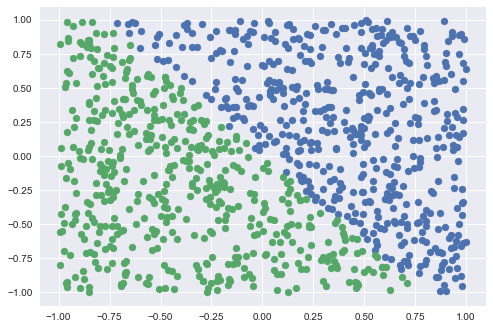

In [2]:
dim = 2
n = 1000
points, labels = DataGenerator.random_halfspace_data(dim, n)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels
zeros = np.invert(labels)
print(np.sum(ones), np.sum(zeros))
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.legend()
plt.show()

## Visualize random ReLU data

Note: Sometimes, all points end up having the same label.

points: (1000, 2) float32
labels: (1000,) int64


..\DataGenerator.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out2 = F.softmax(torch.matmul(out1, w1))


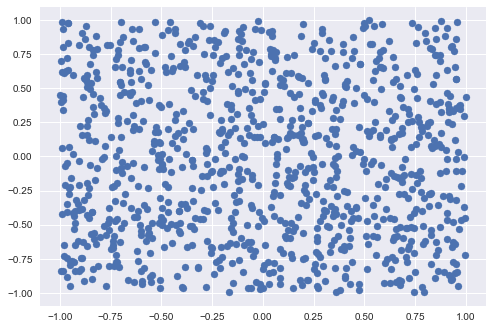

In [3]:
dim = 2
n = 1000
k = 10
points, labels = DataGenerator.layer_relu_data(dim, n, k)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels.astype(np.bool)
zeros = np.invert(ones)
# ax.scatter(points[:, 0][ones], points[:, 1][ones], labels[ones])
# ax.scatter(points[:, 0][zeros], points[:, 1][zeros], labels[zeros])
plt.scatter(points[:, 0][ones], points[:, 1][ones], label='1')
plt.scatter(points[:, 0][zeros], points[:, 1][zeros], label='0')
# plt.legend()
plt.show()

## Visualize MNIST

In [4]:
import torchvision
import torchvision.datasets
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
print('mnist_train:', len(mnist_train))
print('mnist_test:', len(mnist_test))

mnist_train: 60000
mnist_test: 10000


In [5]:
X = np.array([np.array(pair[0]) for pair in mnist_train]) / 255.0
y = np.array([pair[1] for pair in mnist_train])
X_test = np.array([np.array(pair[0]) for pair in mnist_test]) / 255.0
y_test = np.array([pair[1] for pair in mnist_test])
print('X:', X.shape)
print('y:', y.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
mnist_X, mnist_y, mnist_X_test, mnist_y_test = X, y, X_test, y_test

X: (60000, 28, 28)
y: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


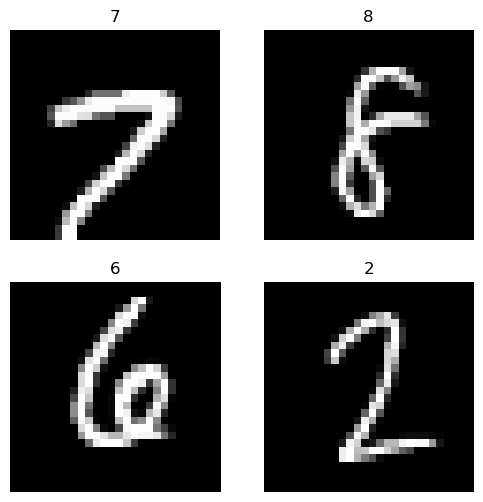

In [6]:
plt.style.use('default')
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(X[123], cmap='gray')
ax[0, 0].set_title(y[123])
ax[0, 1].imshow(X[456], cmap='gray')
ax[0, 1].set_title(y[456])
ax[1, 0].imshow(X_test[123], cmap='gray')
ax[1, 0].set_title(y_test[123])
ax[1, 1].imshow(X_test[456], cmap='gray')
ax[1, 1].set_title(y_test[456])
ax[0, 0].axis('off')
ax[0, 1].axis('off')
ax[1, 0].axis('off')
ax[1, 1].axis('off')
plt.show()
plt.style.use('seaborn')

## Instantiate and inspect RNN

This is based on the README. Notes:

* The "rounds" parameter seems to be defined as T-1, so rounds=1 <=> T=2!

* The word "graph" in the code refers to the recurrent portion of the RNN, i.e. the randomly, sparsely connected part, excluding input and output neurons.

* I'm not sure as to what the best options are for which scenario, feel free to experiment with this.

In [7]:
options = LocalNetBase.Options(
    use_input_rule = False,    # Use an input rule to update input layer weights.
    use_output_rule = True,   # Use an output rule to update input layer weights.
    gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    use_graph_rule = True,
    gd_graph_rule = True,
    gd_input = True,          # gd directly on input layer weights.
    gd_output = False,         # gd directly on output layer weights.
    additive_rule = True)      # If false, uses multiplicative updates.

scheme = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      # By default, uses cross entropy loss.
    mse_loss = False,
    update_misclassified_only = True,    # By default only update weights when we misclassify.
    update_all_edges = False)       # For output rule, update all edges, or only edge to correct and predicted label.

local_net = network.LocalNet(n = 4,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
    
print('local_net input_rule:')
print(local_net.input_rule)  # 2^T, randomly initialized
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # 2^T x 2^T, randomly initialized
print('local_net output_rule:')
print(local_net.get_output_rule())  # 2^T x 2, all zero

local_net input_rule:
tensor([ 0.6860,  0.0988, -0.0336, -1.3635])
local_net rnn_rule:
tensor([[ 0.2526,  0.2430,  0.5320, -1.8474],
        [-0.6099,  0.8262, -1.0756, -1.5485],
        [-0.5230,  1.0836,  0.0034, -0.2421],
        [ 1.7492, -0.7930,  0.6020,  0.4359]])
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Meta-learn rules using gradient descent on halfspace

  0%|                               | 0/20 [00:00<?, ?it/s]

Start meta-learning over outer (rule) epochs...


  5%|█▏                     | 1/20 [00:02<00:40,  2.14s/it]

Acc of class 0 : 0.3419
Acc of class 1 : 1.0000
Train accuracy: 0.6785
Acc of class 0 : 0.3539
Acc of class 1 : 1.0000
Test accuracy: 0.6860
Current loss: 0.6898
Mean loss so far: 0.6898


 10%|██▎                    | 2/20 [00:04<00:37,  2.09s/it]

Acc of class 0 : 0.8096
Acc of class 1 : 0.7849
Train accuracy: 0.7970
Acc of class 0 : 0.8230
Acc of class 1 : 0.8016
Test accuracy: 0.8120
Current loss: 0.6849
Mean loss so far: 0.6874


 15%|███▍                   | 3/20 [00:06<00:34,  2.04s/it]

Acc of class 0 : 0.3961
Acc of class 1 : 0.9990
Train accuracy: 0.7045
Acc of class 0 : 0.3930
Acc of class 1 : 0.9981
Test accuracy: 0.7040
Current loss: 0.6805
Mean loss so far: 0.6851


 20%|████▌                  | 4/20 [00:07<00:31,  1.98s/it]

Acc of class 0 : 0.9980
Acc of class 1 : 0.5767
Train accuracy: 0.7825
Acc of class 0 : 1.0000
Acc of class 1 : 0.5681
Test accuracy: 0.7780
Current loss: 0.6778
Mean loss so far: 0.6833


 25%|█████▊                 | 5/20 [00:09<00:29,  1.94s/it]

Acc of class 0 : 0.5496
Acc of class 1 : 0.9228
Train accuracy: 0.7405
Acc of class 0 : 0.6132
Acc of class 1 : 0.9261
Test accuracy: 0.7740
Current loss: 0.6775
Mean loss so far: 0.6821


 30%|██████▉                | 6/20 [00:11<00:26,  1.91s/it]

Acc of class 0 : 0.6899
Acc of class 1 : 0.9961
Train accuracy: 0.8465
Acc of class 0 : 0.6955
Acc of class 1 : 1.0000
Test accuracy: 0.8520
Current loss: 0.6801
Mean loss so far: 0.6818


 35%|████████               | 7/20 [00:13<00:24,  1.89s/it]

Acc of class 0 : 0.8823
Acc of class 1 : 0.7742
Train accuracy: 0.8270
Acc of class 0 : 0.8683
Acc of class 1 : 0.7743
Test accuracy: 0.8200
Current loss: 0.6812
Mean loss so far: 0.6817


 40%|█████████▏             | 8/20 [00:15<00:22,  1.85s/it]

Acc of class 0 : 0.7861
Acc of class 1 : 0.9609
Train accuracy: 0.8755
Acc of class 0 : 0.7695
Acc of class 1 : 0.9591
Test accuracy: 0.8670
Current loss: 0.6837
Mean loss so far: 0.6820


 45%|██████████▎            | 9/20 [00:17<00:20,  1.85s/it]

Acc of class 0 : 0.8925
Acc of class 1 : 0.7458
Train accuracy: 0.8175
Acc of class 0 : 0.8807
Acc of class 1 : 0.7315
Test accuracy: 0.8040
Current loss: 0.6857
Mean loss so far: 0.6824


 50%|███████████           | 10/20 [00:18<00:18,  1.83s/it]

Acc of class 0 : 0.9795
Acc of class 1 : 0.8866
Train accuracy: 0.9320
Acc of class 0 : 0.9753
Acc of class 1 : 0.8638
Test accuracy: 0.9180
Current loss: 0.6883
Mean loss so far: 0.6830


 55%|████████████          | 11/20 [00:20<00:16,  1.82s/it]

Acc of class 0 : 0.9969
Acc of class 1 : 0.5777
Train accuracy: 0.7825
Acc of class 0 : 0.9918
Acc of class 1 : 0.5525
Test accuracy: 0.7660
Current loss: 0.6897
Mean loss so far: 0.6836


 60%|█████████████▏        | 12/20 [00:22<00:14,  1.80s/it]

Acc of class 0 : 0.9867
Acc of class 1 : 0.8065
Train accuracy: 0.8945
Acc of class 0 : 0.9794
Acc of class 1 : 0.7743
Test accuracy: 0.8740
Current loss: 0.6909
Mean loss so far: 0.6842


 65%|██████████████▎       | 13/20 [00:24<00:12,  1.80s/it]

Acc of class 0 : 0.9089
Acc of class 1 : 0.7869
Train accuracy: 0.8465
Acc of class 0 : 0.9156
Acc of class 1 : 0.7763
Test accuracy: 0.8440
Current loss: 0.6913
Mean loss so far: 0.6847


 70%|███████████████▍      | 14/20 [00:25<00:10,  1.80s/it]

Acc of class 0 : 0.9621
Acc of class 1 : 0.8798
Train accuracy: 0.9200
Acc of class 0 : 0.9671
Acc of class 1 : 0.8580
Test accuracy: 0.9110
Current loss: 0.6918
Mean loss so far: 0.6852


 75%|████████████████▌     | 15/20 [00:27<00:09,  1.80s/it]

Acc of class 0 : 0.9939
Acc of class 1 : 0.7967
Train accuracy: 0.8930
Acc of class 0 : 0.9877
Acc of class 1 : 0.7938
Test accuracy: 0.8880
Current loss: 0.6922
Mean loss so far: 0.6857


 80%|█████████████████▌    | 16/20 [00:29<00:07,  1.78s/it]

Acc of class 0 : 0.8710
Acc of class 1 : 0.9140
Train accuracy: 0.8930
Acc of class 0 : 0.8580
Acc of class 1 : 0.8969
Test accuracy: 0.8780
Current loss: 0.6925
Mean loss so far: 0.6861


 85%|██████████████████▋   | 17/20 [00:31<00:05,  1.78s/it]

Acc of class 0 : 0.8813
Acc of class 1 : 0.9511
Train accuracy: 0.9170
Acc of class 0 : 0.8827
Acc of class 1 : 0.9300
Test accuracy: 0.9070
Current loss: 0.6928
Mean loss so far: 0.6865


 90%|███████████████████▊  | 18/20 [00:33<00:03,  1.78s/it]

Acc of class 0 : 0.6643
Acc of class 1 : 1.0000
Train accuracy: 0.8360
Acc of class 0 : 0.6420
Acc of class 1 : 0.9981
Test accuracy: 0.8250
Current loss: 0.6929
Mean loss so far: 0.6869


 95%|████████████████████▉ | 19/20 [00:34<00:01,  1.80s/it]

Acc of class 0 : 0.9079
Acc of class 1 : 0.9326
Train accuracy: 0.9205
Acc of class 0 : 0.9321
Acc of class 1 : 0.9202
Test accuracy: 0.9260
Current loss: 0.6930
Mean loss so far: 0.6872


100%|██████████████████████| 20/20 [00:36<00:00,  1.84s/it]

Acc of class 0 : 0.7861
Acc of class 1 : 0.9863
Train accuracy: 0.8885
Acc of class 0 : 0.7881
Acc of class 1 : 0.9767
Test accuracy: 0.8850
Current loss: 0.6930
Mean loss so far: 0.6875


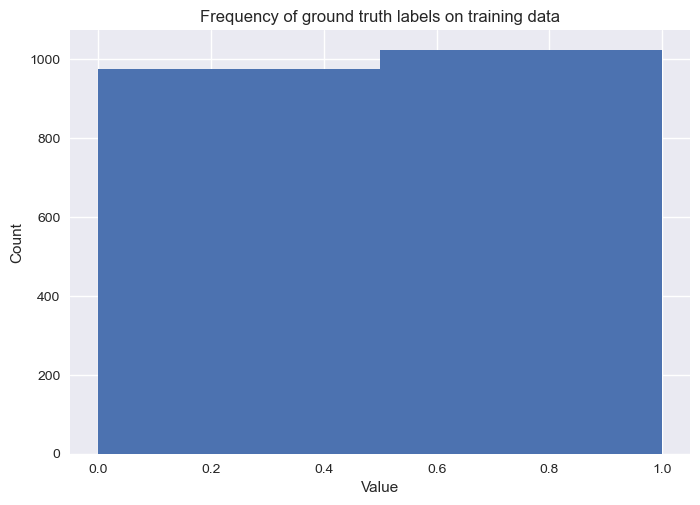

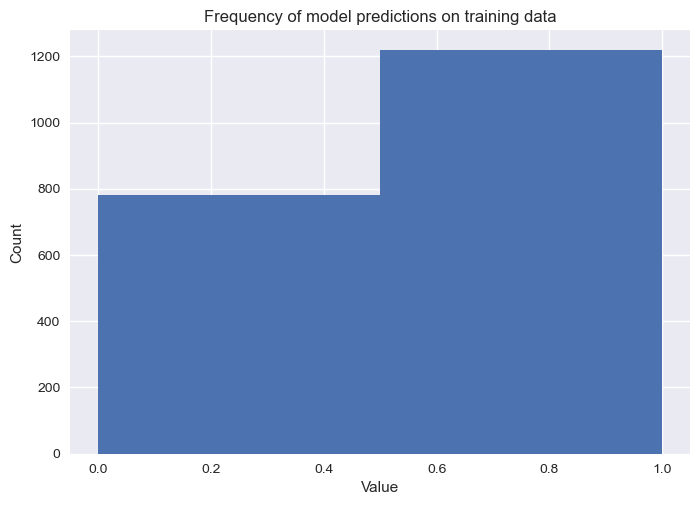

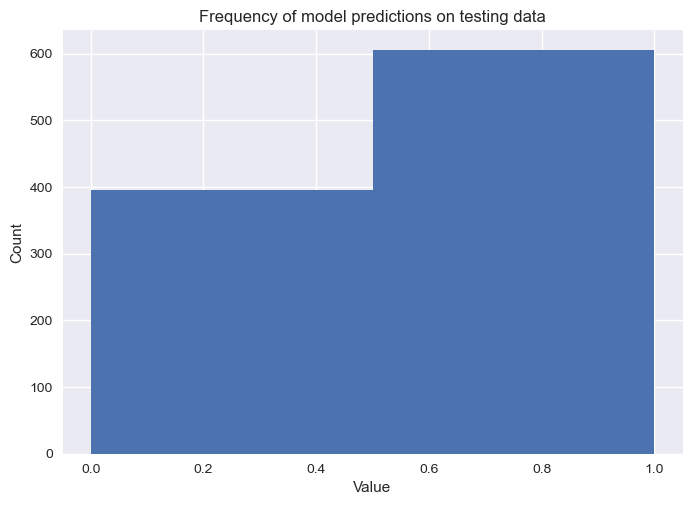

Last loss: 0.6930
Last train accuracy: 0.8885
Last test accuracy: 0.8850


In [8]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Meta-learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X,                      # Training inputs
    y,                      # Training labels
    local_net,              # The BrainNet
    num_rule_epochs = 20,   # Number of meta-learning epochs
    num_epochs = 2,         # Number of times to process a single batch
    batch_size = 100,       # Number of samples in a batch
    learn_rate = 1e-2,      # Learning rate
    X_test = X_test,
    y_test = y_test,
    verbose = True)

In [9]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.6930
Last train accuracy: 0.8885
Last test accuracy: 0.8850


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


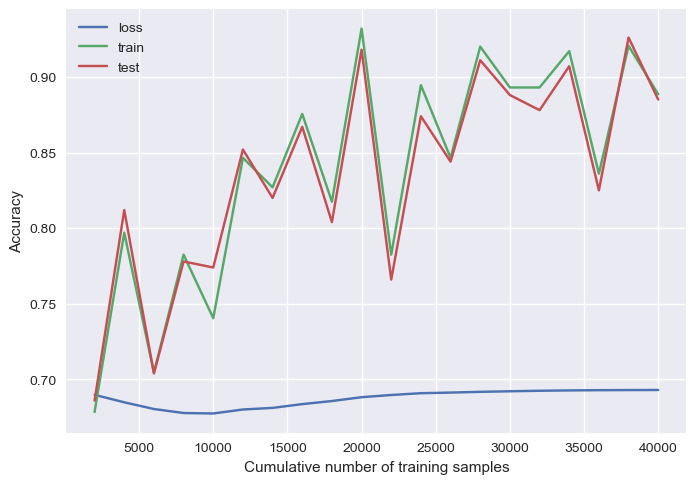

In [10]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Print rules.
print('local_net input_rule:')
print(local_net.input_rule)  # Same as before (cannot be learned?).
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # Learned.
print('local_net output_rule:')
print(local_net.get_output_rule())  # Same as before (we specified not to learn this).

local_net input_rule:
tensor([ 0.6860,  0.0988, -0.0336, -1.3635])
local_net rnn_rule:
tensor([[ 0.0252,  0.0216,  0.0109, -0.0146],
        [ 0.0333,  0.0400,  0.0083,  0.0146],
        [ 0.0217,  0.0386,  0.0189,  0.0252],
        [ 0.0336,  0.0132,  0.0228,  0.0368]], dtype=torch.float64)
local_net output_rule:
tensor([[-0.0566,  0.0566],
        [ 0.0519, -0.0519],
        [ 0.0299, -0.0299],
        [ 0.1639, -0.1639]], dtype=torch.float64)


## Train with the already learned rules on a different halfspace

===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
INITIAL train accuracy: 0.4885


  0%|                             | 0/2000 [00:00<?, ?it/s]

Acc of class 0 : 1.0000
Acc of class 1 : 0.0000
INITIAL test accuracy: 0.4830
Epoch 1 / 5 ...


 29%|█████▏            | 573/2000 [00:00<00:01, 948.18it/s]

Acc of class 0 : 0.8915
Acc of class 1 : 0.9707
Step 500 / 2000
Train accuracy: 0.9320
Acc of class 0 : 0.8716
Acc of class 1 : 0.9671
Test accuracy: 0.9210
Current loss: 0.6931
Mean loss so far: 0.3465


 58%|█████████▎      | 1164/2000 [00:01<00:00, 1029.22it/s]

Acc of class 0 : 0.9376
Acc of class 1 : 0.9462
Step 1000 / 2000
Train accuracy: 0.9420
Acc of class 0 : 0.9296
Acc of class 1 : 0.9478
Test accuracy: 0.9390
Current loss: 0.6928
Mean loss so far: 0.4620


 83%|█████████████▏  | 1651/2000 [00:01<00:00, 1027.73it/s]

Acc of class 0 : 0.9253
Acc of class 1 : 0.9717
Step 1500 / 2000
Train accuracy: 0.9490
Acc of class 0 : 0.9193
Acc of class 1 : 0.9710
Test accuracy: 0.9460
Current loss: 0.6926
Mean loss so far: 0.5196


  6%|█                | 120/2000 [00:00<00:01, 1198.90it/s]

Acc of class 0 : 0.9672
Acc of class 1 : 0.9120
Step 2000 / 2000
Train accuracy: 0.9390
Acc of class 0 : 0.9565
Acc of class 1 : 0.8994
Test accuracy: 0.9270
Current loss: 0.6924
Mean loss so far: 0.5542

Epoch 2 / 5 ...


 34%|█████▊           | 688/2000 [00:00<00:01, 1007.68it/s]

Acc of class 0 : 0.9560
Acc of class 1 : 0.9609
Step 500 / 2000
Train accuracy: 0.9585
Acc of class 0 : 0.9462
Acc of class 1 : 0.9710
Test accuracy: 0.9590
Current loss: 0.6922
Mean loss so far: 0.5772


 58%|█████████▊       | 1160/2000 [00:01<00:00, 996.88it/s]

Acc of class 0 : 0.9918
Acc of class 1 : 0.9091
Step 1000 / 2000
Train accuracy: 0.9495
Acc of class 0 : 0.9896
Acc of class 1 : 0.9014
Test accuracy: 0.9440
Current loss: 0.6920
Mean loss so far: 0.5936


 82%|█████████████   | 1631/2000 [00:01<00:00, 1000.46it/s]

Acc of class 0 : 0.9406
Acc of class 1 : 0.9599
Step 1500 / 2000
Train accuracy: 0.9505
Acc of class 0 : 0.9193
Acc of class 1 : 0.9671
Test accuracy: 0.9440
Current loss: 0.6918
Mean loss so far: 0.6059


  6%|█                | 118/2000 [00:00<00:01, 1178.85it/s]

Acc of class 0 : 0.8976
Acc of class 1 : 0.9824
Step 2000 / 2000
Train accuracy: 0.9410
Acc of class 0 : 0.8592
Acc of class 1 : 0.9807
Test accuracy: 0.9220
Current loss: 0.6917
Mean loss so far: 0.6154

Epoch 3 / 5 ...


 29%|█████▎            | 586/2000 [00:00<00:01, 968.51it/s]

Acc of class 0 : 0.9734
Acc of class 1 : 0.9648
Step 500 / 2000
Train accuracy: 0.9690
Acc of class 0 : 0.9586
Acc of class 1 : 0.9652
Test accuracy: 0.9620
Current loss: 0.6913
Mean loss so far: 0.6230


 59%|█████████▍      | 1185/2000 [00:01<00:00, 1012.37it/s]

Acc of class 0 : 0.9601
Acc of class 1 : 0.9286
Step 1000 / 2000
Train accuracy: 0.9440
Acc of class 0 : 0.9545
Acc of class 1 : 0.9072
Test accuracy: 0.9300
Current loss: 0.6911
Mean loss so far: 0.6292


 83%|█████████████▎  | 1666/2000 [00:01<00:00, 1010.72it/s]

Acc of class 0 : 0.9908
Acc of class 1 : 0.8798
Step 1500 / 2000
Train accuracy: 0.9340
Acc of class 0 : 0.9855
Acc of class 1 : 0.8665
Test accuracy: 0.9240
Current loss: 0.6910
Mean loss so far: 0.6343


  5%|▉                | 109/2000 [00:00<00:01, 1089.01it/s]

Acc of class 0 : 0.9406
Acc of class 1 : 0.9668
Step 2000 / 2000
Train accuracy: 0.9540
Acc of class 0 : 0.9151
Acc of class 1 : 0.9536
Test accuracy: 0.9350
Current loss: 0.6908
Mean loss so far: 0.6387

Epoch 4 / 5 ...


 29%|█████▏            | 576/2000 [00:00<00:01, 934.89it/s]

Acc of class 0 : 0.9846
Acc of class 1 : 0.9345
Step 500 / 2000
Train accuracy: 0.9590
Acc of class 0 : 0.9731
Acc of class 1 : 0.9323
Test accuracy: 0.9520
Current loss: 0.6903
Mean loss so far: 0.6424


 58%|█████████▉       | 1169/2000 [00:01<00:00, 997.93it/s]

Acc of class 0 : 0.9969
Acc of class 1 : 0.8602
Step 1000 / 2000
Train accuracy: 0.9270
Acc of class 0 : 0.9938
Acc of class 1 : 0.8298
Test accuracy: 0.9090
Current loss: 0.6900
Mean loss so far: 0.6455


 83%|█████████████▎  | 1660/2000 [00:01<00:00, 1027.83it/s]

Acc of class 0 : 0.9591
Acc of class 1 : 0.9501
Step 1500 / 2000
Train accuracy: 0.9545
Acc of class 0 : 0.9482
Acc of class 1 : 0.9362
Test accuracy: 0.9420
Current loss: 0.6894
Mean loss so far: 0.6483


  6%|▉                | 117/2000 [00:00<00:01, 1168.94it/s]

Acc of class 0 : 0.9601
Acc of class 1 : 0.9648
Step 2000 / 2000
Train accuracy: 0.9625
Acc of class 0 : 0.9524
Acc of class 1 : 0.9594
Test accuracy: 0.9560
Current loss: 0.6896
Mean loss so far: 0.6507

Epoch 5 / 5 ...


 30%|█████            | 593/2000 [00:00<00:01, 1001.10it/s]

Acc of class 0 : 0.9539
Acc of class 1 : 0.9677
Step 500 / 2000
Train accuracy: 0.9610
Acc of class 0 : 0.9462
Acc of class 1 : 0.9691
Test accuracy: 0.9580
Current loss: 0.6890
Mean loss so far: 0.6528


 54%|█████████▏       | 1083/2000 [00:00<00:00, 991.18it/s]

Acc of class 0 : 0.9642
Acc of class 1 : 0.9599
Step 1000 / 2000
Train accuracy: 0.9620
Acc of class 0 : 0.9565
Acc of class 1 : 0.9574
Test accuracy: 0.9570
Current loss: 0.6886
Mean loss so far: 0.6547


 84%|█████████████▎  | 1671/2000 [00:01<00:00, 1000.57it/s]

Acc of class 0 : 0.9898
Acc of class 1 : 0.9062
Step 1500 / 2000
Train accuracy: 0.9470
Acc of class 0 : 0.9772
Acc of class 1 : 0.9091
Test accuracy: 0.9420
Current loss: 0.6883
Mean loss so far: 0.6564


100%|████████████████| 2000/2000 [00:01<00:00, 1064.59it/s]

Acc of class 0 : 0.9089
Acc of class 1 : 0.9873
Step 2000 / 2000
Train accuracy: 0.9490
Acc of class 0 : 0.9048
Acc of class 1 : 0.9749
Test accuracy: 0.9410
Current loss: 0.6883
Mean loss so far: 0.6579



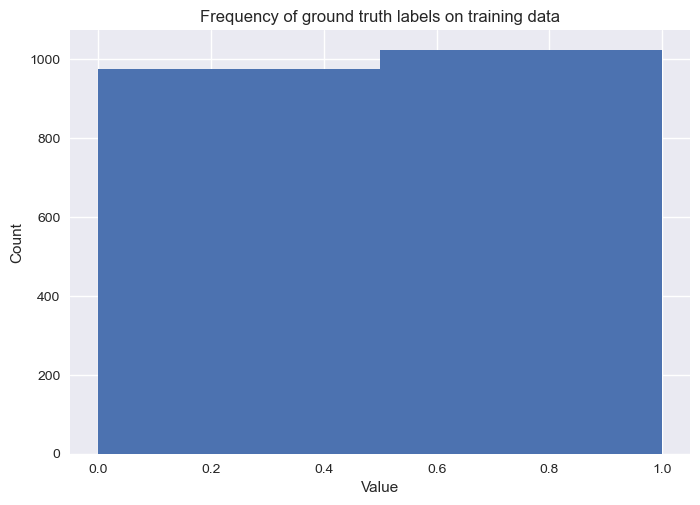

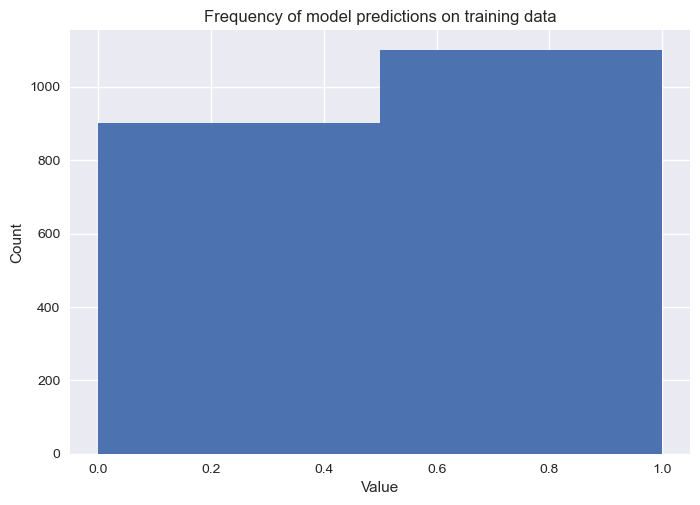

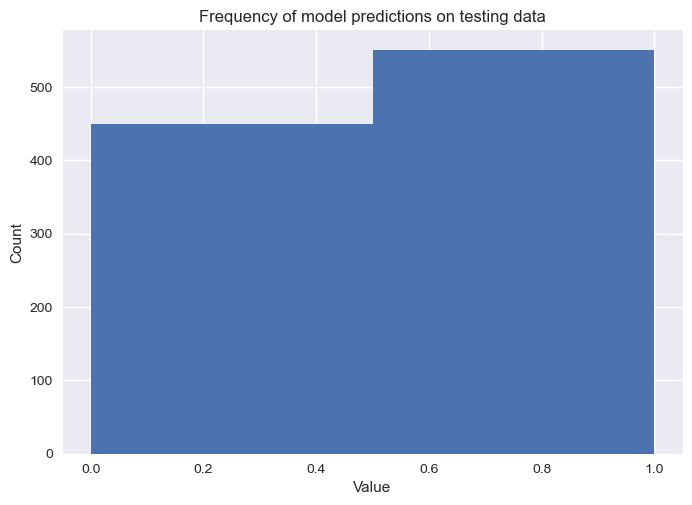

Last loss: 0.6883
Last train accuracy: 0.9490
Last test accuracy: 0.9410


In [12]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# NOTE: This is the old-school way that is NOT recommended by Basile.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X, y, local_net,
    num_epochs = 5,
    batch_size = 1,
    vanilla = False,
    learn_rate = 1e-2,
    X_test = X_test,
    y_test = y_test,
    verbose = True,
    disable_backprop = True)

In [13]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.6883
Last train accuracy: 0.9490
Last test accuracy: 0.9410


all_losses: (21,)
all_train_acc: (21,)
all_test_acc: (21,)
sample_counts: (21,)


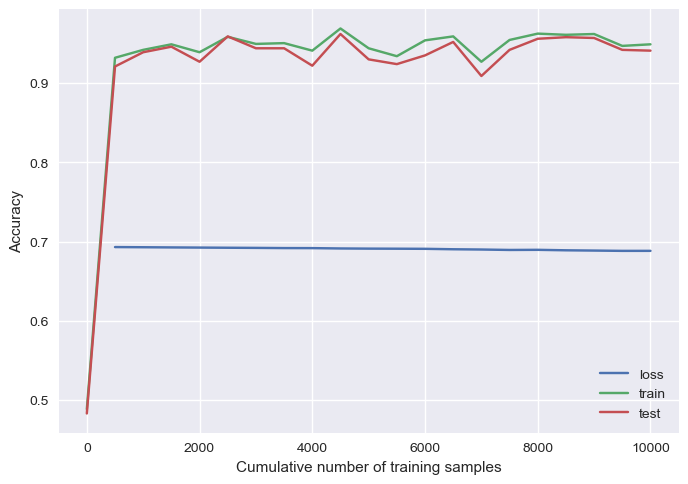

In [14]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Meta-learn rules on halfspace, train with fixed rules on MNIST

We create different upstream (halfspace) vs downstream (MNIST) network.

NOTE: the reason this doesn't work too well is because the actual procedures in the paper are a little more complicated, see **Appendix A.2**. I am using a halfspace dimension of 8 and MNIST is 28 x 28, and then the rules are copied across different networks.

Interestingly, even if the upstream accuracy is chance (50%), the downstream training still works sometimes...

In [15]:
options = LocalNetBase.Options(
    gd_input = True,          # GD directly on input layer weights.
    use_graph_rule = True,
    gd_graph_rule = True,
    use_output_rule = True,   # Use an output rule to update input layer weights.
    gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    gd_output = False,        # GD directly on output layer weights.
    additive_rule = True)     # If false, uses multiplicative updates.

# ==== TODO: improve this to match paper ====

# Initialize new network.
dimension = 8
local_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)

# Generate halfspace data.
n = 4000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X, y, local_net, num_rule_epochs=20, num_epochs=2, batch_size=100, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False)

100%|██████████████████████| 20/20 [02:15<00:00,  6.76s/it]

Last loss: 0.5568
Last train accuracy: 0.9010
Last test accuracy: 0.9095


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


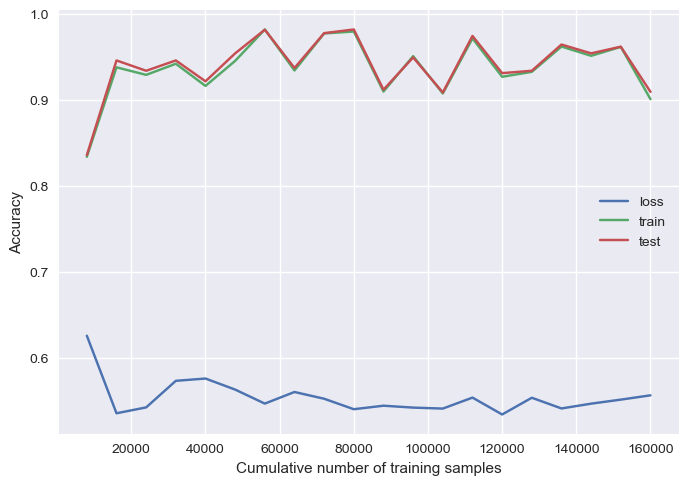

In [16]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Transfer rules to new model
dimension = 28 * 28
mnist_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 10,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
# mnist_net.set_rnn_rule(local_net.get_rnn_rule())
# mnist_net.set_output_rule(local_net.get_output_rule())
mnist_net.rnn_rule = local_net.rnn_rule
mnist_net.output_rule = local_net.output_rule

# Recall MNIST data.
X, y, X_test, y_test = mnist_X, mnist_y, mnist_X_test, mnist_y_test
X = X.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X, y, mnist_net, num_epochs=1, batch_size=1, vanilla=False, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=3000, disable_backprop=True)

===> WARNING: Backprop is disabled, which means that all layers without rules will never change their weights!
===> This is NOT recommended by Basile!
INITIAL train accuracy: 0.0904
INITIAL test accuracy: 0.0892
Epoch 1 / 1 ...


100%|███████████████| 60000/60000 [02:23<00:00, 418.27it/s]


Last loss: 1.6099
Last train accuracy: 0.5941
Last test accuracy: 0.5882


all_losses: (21,)
all_train_acc: (21,)
all_test_acc: (21,)
sample_counts: (21,)


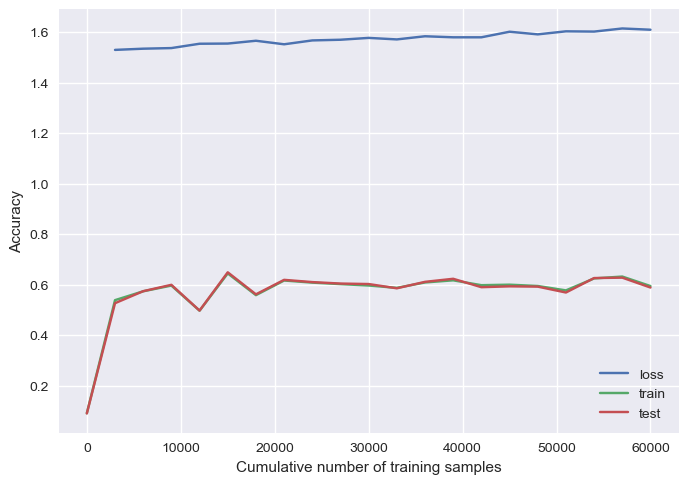

In [18]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()